# Kyoto gas splitter
This notebook uses the kyoto gas splitter to divide up the greenhouse gas projections from the CLimate Action Tracker project. 

In [1]:
import os.path

import pandas as pd
import pyam
import matplotlib.pyplot as plt
import numpy as np
from silicone.utils import (
    _get_unit_of_variable,
    find_matching_scenarios,
    download_or_load_sr15,
    convert_units_to_MtCO2_equiv
)
import silicone.multiple_infillers as mi

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


In [2]:
input_kyoto_file = "./../input/DownloadedClimateActionTrackerData.csv"
input_complete_data = "./../input/sr15_database.csv"
df = download_or_load_sr15(input_complete_data)

pyam.iiasa - INFO: You are connected to the IXSE_SR15 scenario explorer hosted by IIASA. If you use this data in any published format, please cite the data as provided in the explorer guidelines: https://data.ene.iiasa.ac.at/iamc-1.5c-explorer/#/about.


Fetching data for *
Fetching Emissions*
Writing to ./../input/sr15_database.csv


pyam.utils - INFO: Reading `./../input/sr15_database.csv`


We have to format the CVS file to make a pyam dataframe.

In [3]:
kyoto_csv = pd.read_csv(input_kyoto_file, header=[0, 1], index_col=0)
kyoto_csv = kyoto_csv.transpose().reset_index()
kyoto_csv.head()

,level_0,level_1,2010,2011,2012,2013,2014,2015,2016,2017,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,AR5 BAU,high,48.96,50.71,52.46,54.21,55.96,57.71,59.46,61.22,...,162.69,164.07,165.46,166.84,168.22,169.61,170.99,172.38,173.76,175.14
1,AR5 BAU,low,43.80,44.76,45.72,46.68,47.63,48.59,49.55,50.51,...,87.15,86.65,86.15,85.65,85.15,84.65,84.16,83.66,83.16,82.66
2,Pledges and targets,high,48.12,49.16,49.62,50.16,50.32,50.42,50.37,50.80,...,35.77,35.53,35.27,35.01,34.73,34.44,34.14,33.85,33.57,33.31
3,Pledges and targets,low,48.12,49.16,49.62,50.08,49.98,50.16,50.15,50.52,...,28.08,27.84,27.60,27.35,27.10,26.85,26.61,26.38,26.16,25.93
4,Current policy projections,high,48.13,49.18,49.65,50.33,50.46,50.59,50.65,51.22,...,55.05,54.87,54.70,54.53,54.37,54.24,54.12,53.97,53.80,53.64


In [4]:
kyoto_csv = kyoto_csv.rename(columns={"level_0": "model", "level_1": "scenario"})

In [5]:
aggregate = "Emissions|Kyoto Gases (AR4-GWP100)"
kyoto_csv["variable"] = aggregate
kyoto_csv["unit"] = "Mt CO2-equiv/yr" # We will convert units later
kyoto_csv["region"] = "World"

In [6]:
kyoto_df = pyam.IamDataFrame(kyoto_csv).filter(scenario="median", keep=False) # There are too many cases so we leave some out
kyoto_df.data["value"] = kyoto_df.data["value"] * 1000  #The csv values are in Gt CO2-equiv. 
kyoto_df.head()

,model,scenario,region,variable,unit,year,value
0,1.5C consistent,high,World,Emissions|Kyoto Gases (AR4-GWP100),Mt CO2-equiv/yr,2010,48100.0
1,1.5C consistent,high,World,Emissions|Kyoto Gases (AR4-GWP100),Mt CO2-equiv/yr,2011,48670.0
2,1.5C consistent,high,World,Emissions|Kyoto Gases (AR4-GWP100),Mt CO2-equiv/yr,2012,49250.0
3,1.5C consistent,high,World,Emissions|Kyoto Gases (AR4-GWP100),Mt CO2-equiv/yr,2013,49820.0
4,1.5C consistent,high,World,Emissions|Kyoto Gases (AR4-GWP100),Mt CO2-equiv/yr,2014,50390.0


Now we can set up the variables to decompose the aggregate into its components. 

In [7]:
components = [
    "Emissions|CO2",
    "Emissions|CH4",
    "Emissions|N2O",
    "Emissions|F-Gases",
]
unit_consistent_db = convert_units_to_MtCO2_equiv(
    df.filter(variable=components)
)
unit_consistent_db.variables(True)

,variable,unit
0,Emissions|CH4,Mt CO2-equiv/yr
1,Emissions|CO2,Mt CO2/yr
2,Emissions|F-Gases,Mt CO2-equiv/yr
3,Emissions|N2O,Mt CO2-equiv/yr


Our complete dataframe has two extra columns and needs to be made consistent with the kyoto gas dataframe. 

In [8]:
del unit_consistent_db.data["subannual"]
del unit_consistent_db.data["meta"]
unit_consistent_db = pyam.IamDataFrame(unit_consistent_db.data)

We interpolate to ensure that each model is represented in each year, to prevent variation in which models feature in particular years

In [40]:
for year in unit_consistent_db.filter(variable="Emissions|F-Gases")["year"].unique():
    unit_consistent_db.interpolate(year)

In [41]:
decomposer = mi.DecomposeCollectionTimeDepRatio(unit_consistent_db)
results = decomposer.infill_components(
    aggregate, components, 
    kyoto_df.filter(year=unit_consistent_db.filter(variable="Emissions|F-Gases")["year"].unique()), 
    use_ar4_data=True
)
results.head()

,model,scenario,region,variable,unit,year,value
0,1.5C consistent,high,World,Emissions|CH4,Mt CO2-equiv/yr,2010,9671.293549
1,1.5C consistent,high,World,Emissions|CH4,Mt CO2-equiv/yr,2015,9959.317369
2,1.5C consistent,high,World,Emissions|CH4,Mt CO2-equiv/yr,2020,10155.783964
3,1.5C consistent,high,World,Emissions|CH4,Mt CO2-equiv/yr,2025,7490.693789
4,1.5C consistent,high,World,Emissions|CH4,Mt CO2-equiv/yr,2030,5093.648185


In [42]:
results.variables(True)

,variable,unit
0,Emissions|CH4,Mt CO2-equiv/yr
1,Emissions|CO2,Mt CO2/yr
2,Emissions|F-Gases,Mt CO2-equiv/yr
3,Emissions|N2O,Mt CO2-equiv/yr


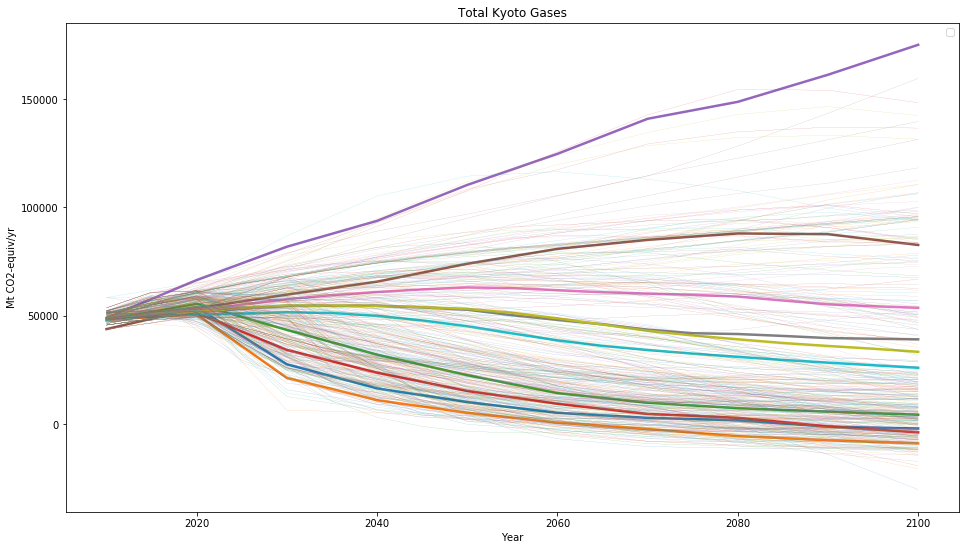

In [43]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
kyoto_df.filter(year=results.data["year"].unique()).line_plot(ax=ax, linewidth = 2.5, label='_nolegend_')
df.filter(variable=aggregate, year=results.data["year"].unique()).line_plot(
    ax=ax, linewidth=0.1, label='_nolegend_', title="Total Kyoto Gases"
)

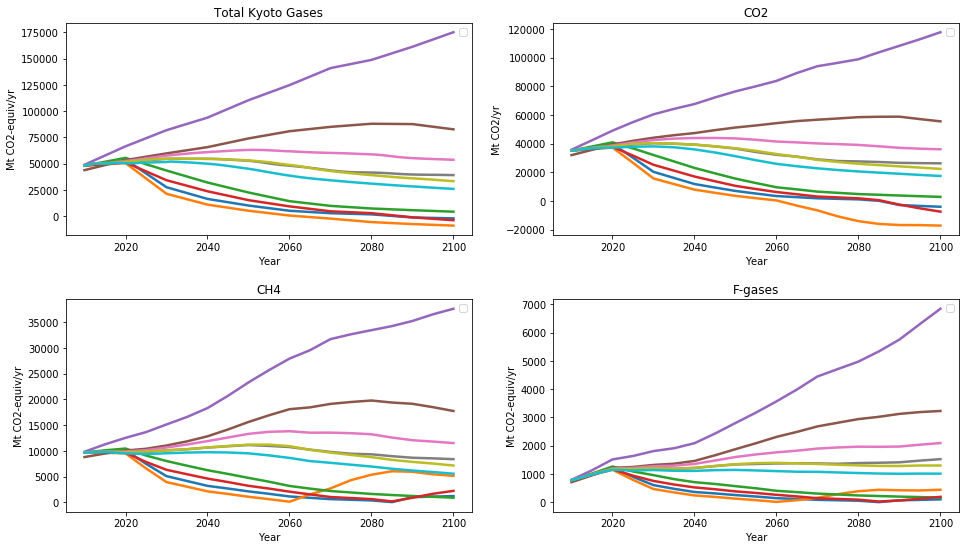

In [44]:
fig = plt.figure(figsize=(16, 9))
fig.subplots_adjust(hspace=.3)
ax = fig.add_subplot(221)
kyoto_df.line_plot(ax=ax, label='_nolegend_', linewidth = 2.5, title="Total Kyoto Gases")
ax = fig.add_subplot(222)
results.filter(variable="Emissions|CO2").line_plot(ax=ax, linewidth = 2.5, label='_nolegend_', title="CO2")
ax = fig.add_subplot(223)
results.filter(variable="Emissions|CH4").line_plot(ax=ax, linewidth = 2.5, label='_nolegend_', title="CH4")
ax = fig.add_subplot(224)
results.filter(variable="Emissions|F-Gases").line_plot(ax=ax, linewidth = 2.5, label='_nolegend_', title="F-gases")